# Predicting House Prices

## Introduction

In this project, I use the [Kaggle dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description). This dataset has been developed in order to examine the factors that influence house prices. 

In [1]:
#Import the packages
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Read in the data
train=pd.read_csv('train.csv')
holdout=pd.read_csv('test.csv')

In [3]:
#Exploring the first few rows of the data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

The data contains 1460 rows and 80 columns. The columns' types are either numeric or object.

In [5]:
#Checking the columns of the data
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

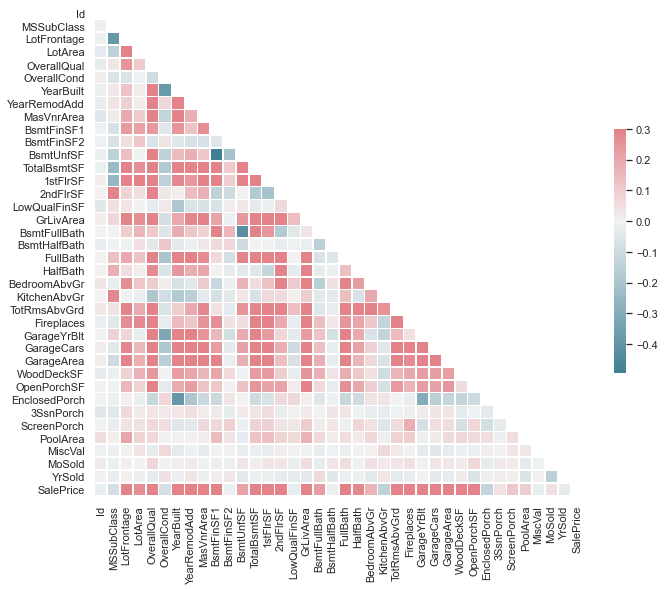

In [6]:
#Plotting correlation between features and target columns
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
plot_correlation_heatmap(train)

## Transforming features and dealing with missing values

First, I concat the train and holdout data frame so that I will have to transform columns and rows with missing values once. After all the transformation and cleaning, I will split the dataframe into train and holdout again.

In [7]:
y_train = train['SalePrice']
holdout_id = holdout['Id']
all_data = pd.concat([train, holdout], axis=0, sort=False)


The transform_features function will create two columns:

- 'Years Before Sale', which is the difference between 'YrSold' and 'YearBuilt'
- 'Years Since Remod', which is the difference between 'YrSold' and 'YearRemodAdd'

I will then remove the columns: 'YrSold','YearBuilt' and 'YearRemodAdd'.

In [8]:
def transform_features(df):
    saleprice=df['SalePrice']
    df=df.drop(['SalePrice'],axis=1)
    years_sold = df['YrSold'] - df['YearBuilt']
    years_since_remod = df['YrSold'] - df['YearRemodAdd']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df=df.drop(['YrSold','YearBuilt','YearRemodAdd'],axis=1)
    df['SalePrice'] = saleprice
    return df

The process_missing function counts the number of null values for each column and remove columns with more than 5% missing values.

In [9]:
def process_missing(df,threshold):
    saleprice=df['SalePrice']
    missing_values=df.isnull().sum()
    missing_cols=missing_values[missing_values/len(df)>threshold].index
    df=df.drop(missing_cols,axis=1)
    df['SalePrice'] = saleprice
    return df

In [10]:
all_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

The fill_na function does the following:

- For numeric columns, the function fills in 0. 
- For object columns, the function fills in the mode of the columns.

In [11]:
def fill_na(df):
    saleprice=df['SalePrice']
    df=df.drop(['SalePrice'],axis=1)
    numeric_cols=df.select_dtypes(include=['integer','float']).columns
    for col in numeric_cols:
        df[col]=df[col].fillna(0)
    object_cols=df.select_dtypes(include=['object']).columns
    for col in object_cols:
        df[col]=df[col].fillna(df[col].mode()[0])
    df['SalePrice'] = saleprice   
    return df

The correlation function calculates the correlation between the feature columns and the target columns. Then it removes columns with low correlations.

In [12]:
def correlation(df,threshold):
    numeric_cols=df.select_dtypes(include=['integer','float'])
    numeric_cols_corr=numeric_cols[numeric_cols.columns[1:-1]].apply(lambda x: abs(x.corr(numeric_cols['SalePrice'])))
    numeric_cols_low_corr=numeric_cols_corr[numeric_cols_corr<threshold].index
    df=df.drop(numeric_cols_low_corr,axis=1)
    df=df.drop(['Id'],axis=1)
    return df

The collinearity function detects high collinearity between features and remove those columns.

In [13]:
def collinearity(df, threshold):
    saleprice=df['SalePrice']
    df=df.drop(['SalePrice'],axis=1)
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in df.columns:
                    del df[colname] # deleting the column from the dataset
    df['SalePrice']=saleprice
    return df

For categorical columns, I create dummy columns to transform them into numeric columns.

In [14]:
def dummy_cols(df):
    cat_columns=df.select_dtypes(exclude=['integer','float']).columns
    dummy_df = pd.get_dummies(df[cat_columns])
    df = pd.concat([df, dummy_df], axis=1)
    df = df.drop(cat_columns, axis=1)
    return df

def correlation(df,threshold):
    corr=df.corr()['SalePrice'][:-1].abs()
    cols=corr[corr<threshold].index
    df=df.drop(cols,axis=1)
    return df

In [15]:
all_data=transform_features(all_data)
all_data=process_missing(all_data,0.05)
all_data=fill_na(all_data)
all_data=dummy_cols(all_data)
all_data=correlation(all_data,0.3)
all_data=collinearity(all_data,0.3)


In [16]:
all_data.columns

Index(['OverallQual', 'BsmtFinSF1', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF',
       'Years Before Sale', 'Neighborhood_NoRidge', 'MasVnrType_Stone',
       'Foundation_CBlock', 'BsmtExposure_No', 'SalePrice'],
      dtype='object')

## Testing the models

In [17]:
x_train =all_data[:len(y_train)]
x_test = all_data[len(y_train):]

The select_features function uses recursive feature elimination and the random forests algorithm to find the best-performing set of features.

In [18]:
def select_features(x_train,y_train):
    # Remove non-numeric columns, columns that have null values
    x_train = x_train.select_dtypes([np.number]).dropna(axis=1)
    all_X = x_train.drop(["SalePrice"],axis=1)
    all_y = y_train
    
    clf = RandomForestRegressor(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(x_train,y_train)

Best Columns 
------------
['OverallQual', 'BsmtFinSF1', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'Years Before Sale', 'Neighborhood_NoRidge', 'MasVnrType_Stone', 'Foundation_CBlock', 'BsmtExposure_No']



In [19]:
#Checking the best features
cols

['OverallQual',
 'BsmtFinSF1',
 '2ndFlrSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'Years Before Sale',
 'Neighborhood_NoRidge',
 'MasVnrType_Stone',
 'Foundation_CBlock',
 'BsmtExposure_No']

I will test the following models using grid search: Linear Regression, K-Neighbors Classifier and Random Forest Regressor. The model, along with its parameters, with the highest score will be chosen.

In [20]:
def select_model(df,features):
    saleprice=df['SalePrice']
    all_X = df.drop(['SalePrice'],axis=1)
    all_y = saleprice

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LinearRegression",
            "estimator": LinearRegression(),
            "hyperparameters":
                {
                    'fit_intercept':['True', 'False'], 
                    'normalize':['True', 'False'], 
                    'copy_X':['True', 'False']
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestRegressor",
            "estimator": RandomForestRegressor(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [10,20,30],
                    "max_features"      : ["auto", "sqrt", "log2"],
                    "min_samples_split" : [2,4,8],
                    "bootstrap": [True, False]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models



In [21]:
#Getting the results from the model using the columns found in the previous step.
result = select_model(x_train,cols)

LinearRegression
----------------
Best Score: 0.7187304111101172
Best Parameters: {'copy_X': 'True', 'fit_intercept': 'True', 'normalize': 'True'}

KNeighborsClassifier
--------------------
Best Score: 0.013013698630136985
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}

RandomForestRegressor
---------------------
Best Score: 0.8105442758812351
Best Parameters: {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 30}



Based on the result, the model with the best score is Random Forest Regressor. The optimal hyperparameters for this model are:

- bootstrap='False'
- max_features='sqrt'
- min_samples_split= 4
- n_estimators= 30

I will use the above model to make a prediction for the test set.

In [22]:
all_X=x_train.drop(['SalePrice'],axis=1)
x_test=x_test.drop(['SalePrice'],axis=1)
knn=RandomForestRegressor(bootstrap= False, max_features= 'sqrt', min_samples_split= 8, n_estimators= 30)
knn.fit(all_X,y_train)
predictions=knn.predict(x_test)

In [23]:
#Printing out the predictions
predictions

array([130793.50793651, 159131.42857143, 173889.81746032, ...,
       177294.53507937, 140424.94285714, 245622.84126984])

In [25]:
#Submitting the data
sub = pd.DataFrame()
sub['Id'] = holdout['Id']
sub['SalePrice'] = predictions
sub.to_csv('khanhmai.csv',index=False)